<a href="https://colab.research.google.com/github/Williamyan123/Cas-Score-Prediction/blob/master/Efficiency_1dCNN_Cas_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams

import theano
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed

%matplotlib inline

In [ ]:
# import dataset as a dataframe
#df = pd.read_csv("Final Processed Cas13 data.csv")
df = pd.read_csv("Cas13_MN908947_NY1-PV08001_Coronavirus_MN908947_NY1_PV08001_3pUTR_polyA_CasRxguides.csv")
df.head()




,GuideName,GuideSeq,GuideScores,quartiles,MatchPos,Rank,standardizedGuideScores
0,crRNA001:1-23,TGTTACACACTGATTAAAGATTG,-0.035923,1,23,0.19100,0.138925
1,crRNA002:2-24,ATGTTACACACTGATTAAAGATT,-0.090644,1,24,0.04494,0.108536
2,crRNA003:3-25,AATGTTACACACTGATTAAAGAT,-0.083683,1,25,0.07303,0.112401
3,crRNA004:4-26,TAATGTTACACACTGATTAAAGA,-0.079507,1,26,0.07865,0.114721
4,crRNA005:5-27,CTAATGTTACACACTGATTAAAG,-0.070085,1,27,0.12920,0.119953


In [ ]:
# one-hot encode the quartile data
'''df = pd.concat([df, pd.get_dummies(df['Q'], prefix = 'Q')], axis = 1)
del df['Q']

df.head()'''

"df = pd.concat([df, pd.get_dummies(df['Q'], prefix = 'Q')], axis = 1)\ndel df['Q']\n\ndf.head()"

In [ ]:
# extract gRNA sequences from dataframe into a numpy array
guide = df['GuideSeq']
guide = guide[pd.notnull].to_numpy()
print(guide)

# extract target site sequences from dataframe into a numpy array
target = df['TargetSite']
target = target[pd.notnull].to_numpy()
print(target)

#extract the guide score into a numpy array
y=df.GuideScores
y = y[pd.notnull].to_numpy()
print(y)
print(len(y))

['TGTTACACACTGATTAAAGATTG' 'ATGTTACACACTGATTAAAGATT'
 'AATGTTACACACTGATTAAAGAT' 'TAATGTTACACACTGATTAAAGA'
 'CTAATGTTACACACTGATTAAAG' 'CCTAATGTTACACACTGATTAAA'
 'CCCTAATGTTACACACTGATTAA' 'TCCCTAATGTTACACACTGATTA'
 'CTCCCTAATGTTACACACTGATT' 'CCTCCCTAATGTTACACACTGAT'
 'TCCTCCCTAATGTTACACACTGA' 'GTCCTCCCTAATGTTACACACTG'
 'AGTCCTCCCTAATGTTACACACT' 'AAGTCCTCCCTAATGTTACACAC'
 'CAAGTCCTCCCTAATGTTACACA' 'TCAAGTCCTCCCTAATGTTACAC'
 'TTCAAGTCCTCCCTAATGTTACA' 'TTTCAAGTCCTCCCTAATGTTAC'
 'CTTTCAAGTCCTCCCTAATGTTA' 'TCTTTCAAGTCCTCCCTAATGTT'
 'CTCTTTCAAGTCCTCCCTAATGT' 'GCTCTTTCAAGTCCTCCCTAATG'
 'GGCTCTTTCAAGTCCTCCCTAAT' 'TGGCTCTTTCAAGTCCTCCCTAA'
 'GTGGCTCTTTCAAGTCCTCCCTA' 'GGTGGCTCTTTCAAGTCCTCCCT'
 'TGGTGGCTCTTTCAAGTCCTCCC' 'GTGGTGGCTCTTTCAAGTCCTCC'
 'TGTGGTGGCTCTTTCAAGTCCTC' 'ATGTGGTGGCTCTTTCAAGTCCT'
 'AATGTGGTGGCTCTTTCAAGTCC' 'AAATGTGGTGGCTCTTTCAAGTC'
 'AAAATGTGGTGGCTCTTTCAAGT' 'GAAAATGTGGTGGCTCTTTCAAG'
 'TGAAAATGTGGTGGCTCTTTCAA' 'GTGAAAATGTGGTGGCTCTTTCA'
 'GGTGAAAATGTGGTGGCTCTTTC' 'CGGTGAAAATGTGGTGGC

KeyError: ignored

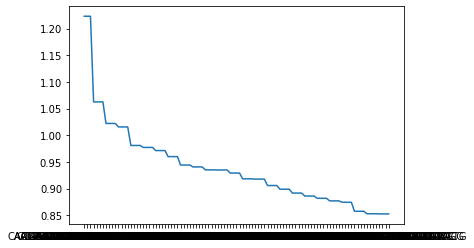

In [ ]:
plt.plot(guide[1:100],y[1:100])

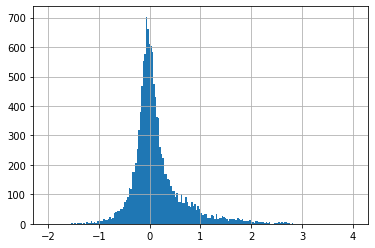

In [ ]:
import math

gscores = []
gscores = df.GuideScores.to_numpy()
gscores = np.sort(gscores)
x = list(range(len(guide)))
#plt.plot(gscores, x)
#plt.show()


df['GuideScores'].hist(bins = 200, range = [-2, 4])

In [ ]:
# splits a string into an array of characters
def split(word): 
    return [char for char in word]  

# transforms a 23 base pair sequence into a one hot encode in the order A, T, G, C
def transform(seq):
  for i in range(len(seq)):
    
    base = seq[i]
    seq.remove(base)

    if base == "A":
      arg = [1,0,0,0]

    elif base == "T":
      arg = [0,1,0,0]

    elif base == "G":
      arg = [0,0,1,0]

    elif base == "C":
      arg = [0,0,0,1]

    else:
      arg = base

    seq.insert(i, arg)

  return seq

In [ ]:
# split target into individual bases
mguide = []
mtarget = []
for i in range(len(guide)):
  mguide.append(split(guide[i]))
  mtarget.append(split(target[i]))

print(mguide)
print(mtarget)
print(mtarget[0])

[['T', 'T', 'A', 'A', 'A', 'A', 'T', 'C', 'A', 'C', 'A', 'T', 'G', 'G', 'G', 'G', 'A', 'T', 'A', 'G', 'C', 'A', 'C'], ['C', 'A', 'C', 'G', 'A', 'T', 'A', 'G', 'G', 'G', 'G', 'T', 'A', 'C', 'A', 'C', 'T', 'A', 'A', 'A', 'A', 'T', 'T'], ['A', 'A', 'T', 'T', 'T', 'T', 'A', 'G', 'T', 'G', 'T', 'A', 'C', 'C', 'C', 'C', 'T', 'A', 'T', 'C', 'G', 'T', 'G'], ['G', 'T', 'G', 'C', 'T', 'A', 'T', 'C', 'C', 'C', 'C', 'A', 'T', 'G', 'T', 'G', 'A', 'T', 'T', 'T', 'T', 'A', 'A'], ['A', 'T', 'T', 'A', 'A', 'T', 'T', 'T', 'T', 'A', 'C', 'A', 'C', 'A', 'T', 'T', 'A', 'G', 'G', 'G', 'C', 'T', 'C'], ['C', 'T', 'C', 'G', 'G', 'G', 'A', 'T', 'T', 'A', 'C', 'A', 'C', 'A', 'T', 'T', 'T', 'T', 'A', 'A', 'T', 'T', 'A'], ['T', 'A', 'A', 'T', 'T', 'A', 'A', 'A', 'A', 'T', 'G', 'T', 'G', 'T', 'A', 'A', 'T', 'C', 'C', 'C', 'G', 'A', 'G'], ['G', 'A', 'G', 'C', 'C', 'C', 'T', 'A', 'A', 'T', 'G', 'T', 'G', 'T', 'A', 'A', 'A', 'A', 'T', 'T', 'A', 'A', 'T'], ['T', 'A', 'G', 'C', 'A', 'T', 'T', 'G', 'T', 'T', 'C', 'A', 'C

In [ ]:
# concatenate the mguide and mtarget arrays into the final encoded format (46*4)
x_encoded=[]
for i in range(len(guide)):
  fguide=[]
  # one-hot encoding of mguide
  fguide = transform(mguide[i])
  ftarget=[]
  #one-hot encoding of mtarget
  ftarget = transform(mtarget[i])
  #fguide = np.array(np.expand_dims(fguide, axis = 1))
  #ftarget = np.array(np.expand_dims(ftarget, axis = 1))
  #final_match = ftarget+fguide
  final_match = np.concatenate((fguide, ftarget), axis=1)
  final_match = final_match.reshape(1,184)
  x_encoded.append(final_match)
# test with one encoded format
print(x_encoded[0])
print(guide[0])
print(x_encoded[0].shape)
# x_final=np.array(x_encoded)
# print(x_final[0]))

[[0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0
  0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0
  0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0
  0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0
  1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1
  0 0 1 0]]
TTAAAATCACATGGGGATAGCAC
(1, 184)


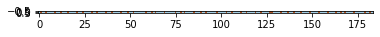

In [ ]:
# graph of the encoded format
plt.imshow(x_encoded[0], cmap = 'Paired', interpolation = 'nearest')

In [ ]:
#adding a dimension to make it compatible with CNN model
x_encoded = np.expand_dims(x_encoded, axis=3)
x_encoded.shape

(12616, 1, 184, 1)

In [ ]:
#split intotraining and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.25, random_state = 42)

print(x_train[0])
print(x_train[0].shape)
print(y_train[1])

[[[1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0]
  [1]
  [0]
  [0]
  [0]
  [0

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import LeakyReLU
from keras.initializers import Constant
import sklearn.metrics as metrics

opt = tf.keras.optimizers.RMSprop(0.001)
dr=0.46
# alp = 0.1
fil= 16
image_shape = (1,184, 1)


model = Sequential()
model.add(Conv1D(filters=fil, kernel_size=8, strides = 8, input_shape=image_shape, activation="relu"))
model.add(Dropout(0.0))
#model.add(MaxPooling2D(pool_size=(2,1)))
model.add(Conv1D(filters=fil, kernel_size=5, input_shape=image_shape, activation="relu"))
model.add(Dropout(0.0))

model.add(Flatten())



model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(dr))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(dr))


model.add(Dense(1))
model.compile(loss='mse', optimizer=opt, metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 23, 16)         144       
_________________________________________________________________
dropout (Dropout)            (None, 1, 23, 16)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 19, 16)         1296      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 19, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 304)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30500     
_________________________________________________________________
activation (Activation)      (None, 100)               0

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 5)

In [ ]:
history = model.fit(x_train, 
                   y_train, 
                   epochs=200, 
                   batch_size = 256,
                  # callbacks=[early_stop],
                   validation_split=0.1)




NameError: ignored

In [ ]:
hist=pd.DataFrame(history.history)
hist['Epoch'] = history.epoch
hist.head()


,loss,mse,val_loss,val_mse,Epoch
0,0.257873,0.257873,0.254507,0.254507,0
1,0.251010,0.251010,0.250293,0.250293,1
2,0.244749,0.244749,0.240883,0.240883,2
3,0.236249,0.236249,0.229566,0.229566,3
4,0.230878,0.230878,0.222361,0.222361,4


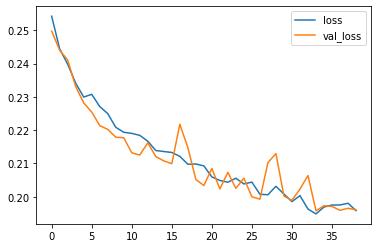

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
from sklearn.metrics import r2_score
training_pred =model.predict(x_train)
training_label=y_train

R_squared_training=r2_score(training_label, training_pred)
print(R_squared_training)

0.7181174046191292


Epoch 1/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1369 - mae: 0.2646 - val_loss: 0.0396 - val_mae: 0.1441
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1382 - mae: 0.2654 - val_loss: 0.0372 - val_mae: 0.1405
Epoch 3/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1374 - mae: 0.2633 - val_loss: 0.0360 - val_mae: 0.1406
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1343 - mae: 0.2620 - val_loss: 0.0342 - val_mae: 0.1374
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1355 - mae: 0.2617 - val_loss: 0.0388 - val_mae: 0.1463
Epoch 6/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1317 - mae: 0.2587 - val_loss: 0.0330 - val_mae: 0.1342
Epoch 7/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1318 - mae: 0.2581 - val_loss: 0.0370 - val_mae: 0.1407
Epoch 8/100
69/69 [==============================] - 0s 4ms/step - loss: 0.1310 - m

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


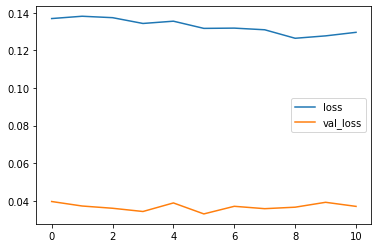

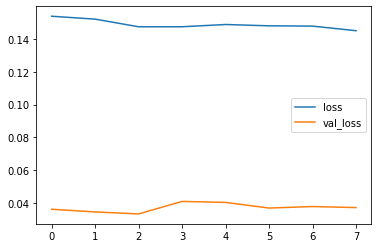

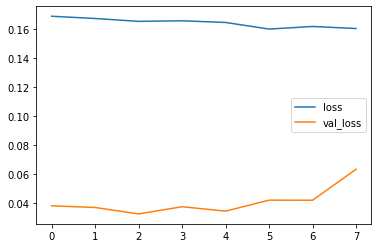

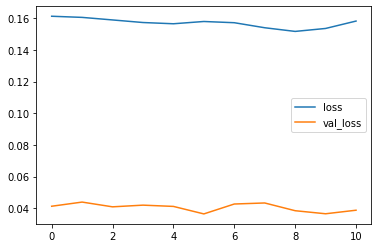

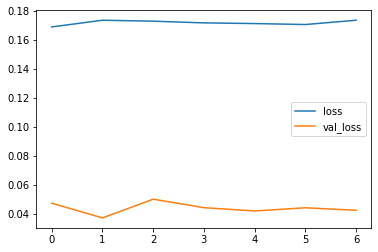

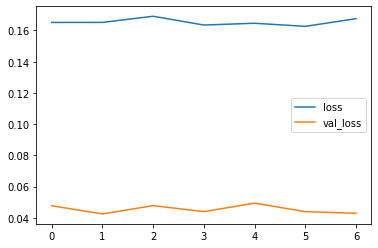

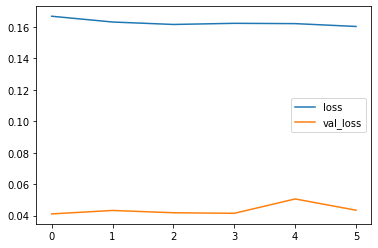

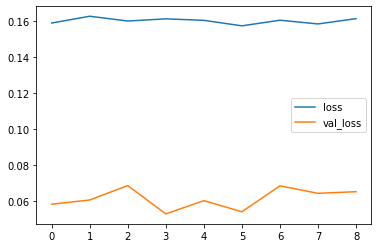

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
kf = KFold(n_splits = 8)
kf.get_n_splits(x_encoded)

scores = []

early_stop = EarlyStopping(monitor='val_loss', patience = 5)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
for train_index, test_index in kf.split(x_encoded):
  #print("TRAIN:", train_index, "TEST:", test_index)
  x_train, x_test = x_encoded[train_index], x_encoded[test_index]
  y_train, y_test = y[train_index], y[test_index]

  result = model.fit(x_train, 
                   y_train, 
                   epochs=100, 
                   batch_size = 128,
                   validation_split=0.2,
                   callbacks = [early_stop])
  
  print(result.history)
  losses = pd.DataFrame(model.history.history)
  losses[['loss','val_loss']].plot()


print(scores)
print(np.mean(scores))
print(np.std(scores, axis=0))

In [ ]:
print(losses['val_loss'])

0     0.252505
1     0.238586
2     0.231321
3     0.219296
4     0.208407
5     0.199962
6     0.200989
7     0.192188
8     0.185664
9     0.188657
10    0.184955
11    0.178949
12    0.181190
13    0.185502
14    0.176271
15    0.180790
16    0.176277
17    0.174262
18    0.173831
19    0.183498
20    0.173355
21    0.168942
22    0.180684
23    0.167093
24    0.174734
25    0.172070
26    0.176104
27    0.169102
28    0.167589
Name: val_loss, dtype: float64


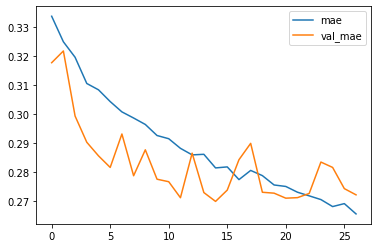

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['mae','val_mae']].plot()

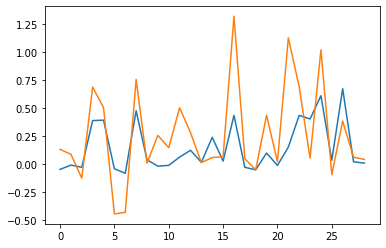

In [ ]:
ran=30
pred = model.predict(x_test[1:ran])
key = y_test[1:ran]
plt.plot(np.arange(ran-1),pred)
plt.plot(np.arange(ran-1),key)

In [ ]:
RNA_input=input()

agcgaaagcaggtactgatccaaaatggaagactttgtgcgacaatgcttcaatccaatgatcatcgagcttgcggaaaaggcaatgaaagaatatggggaagatccgaaaatcgaaactaataagtttgctgcaatatgcacacatttggaagtctgtttcatgtattcagatttccatttcatcgacgaacggggtgaatcaataattgtagaatctggtgacccgaatgctctattgaagcaccgatttgaaataattgaaggaagagaccgaatcatggcctggacagtggtgaacagtatatgtaacacaacaggggtagagaagcctaaatttcttcctgatttgtatgattacaaagagaaccggttcattgaaattggggtgacacggagggaagtccacatatattacttagagaaagccaacaaaataaaatctgagaagacacacattcacatcttttcattcactggagaggagatggccactaaagcggactacacccttgacgaagagagcagggcaagaatcaaaactaggcttttcactataagacaagaaatggccagtaggagcctatgggattcctttcgtcagtccgaaagaggcgaagagacaattgaagaaaagtttgagattacaggaactatgcgcaagcttgccgaccaaagtctcccaccaaacttctcaagcctcgaaaacttcagagcctatgtagat


In [ ]:
RNA_sequence=split(RNA_input.upper())
print(RNA_sequence)

['A', 'G', 'C', 'G', 'A', 'A', 'A', 'G', 'C', 'A', 'G', 'G', 'T', 'A', 'C', 'T', 'G', 'A', 'T', 'C', 'C', 'A', 'A', 'A', 'A', 'T', 'G', 'G', 'A', 'A', 'G', 'A', 'C', 'T', 'T', 'T', 'G', 'T', 'G', 'C', 'G', 'A', 'C', 'A', 'A', 'T', 'G', 'C', 'T', 'T', 'C', 'A', 'A', 'T', 'C', 'C', 'A', 'A', 'T', 'G', 'A', 'T', 'C', 'A', 'T', 'C', 'G', 'A', 'G', 'C', 'T', 'T', 'G', 'C', 'G', 'G', 'A', 'A', 'A', 'A', 'G', 'G', 'C', 'A', 'A', 'T', 'G', 'A', 'A', 'A', 'G', 'A', 'A', 'T', 'A', 'T', 'G', 'G', 'G', 'G', 'A', 'A', 'G', 'A', 'T', 'C', 'C', 'G', 'A', 'A', 'A', 'A', 'T', 'C', 'G', 'A', 'A', 'A', 'C', 'T', 'A', 'A', 'T', 'A', 'A', 'G', 'T', 'T', 'T', 'G', 'C', 'T', 'G', 'C', 'A', 'A', 'T', 'A', 'T', 'G', 'C', 'A', 'C', 'A', 'C', 'A', 'T', 'T', 'T', 'G', 'G', 'A', 'A', 'G', 'T', 'C', 'T', 'G', 'T', 'T', 'T', 'C', 'A', 'T', 'G', 'T', 'A', 'T', 'T', 'C', 'A', 'G', 'A', 'T', 'T', 'T', 'C', 'C', 'A', 'T', 'T', 'T', 'C', 'A', 'T', 'C', 'G', 'A', 'C', 'G', 'A', 'A', 'C', 'G', 'G', 'G', 'G', 'T', 'G', 'A',

In [ ]:
RNA_target = []
RNA_genome_target=[]
for j in range (len(RNA_sequence)-23):
  new_target=[]
  for i in range(0,23):
    new_target.append(RNA_sequence[j+i])
  RNA_genome_target.append(new_target[::-1])
print(RNA_genome_target)



[['A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G', 'C', 'G', 'A'], ['A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G', 'C', 'G'], ['A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G', 'C'], ['T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G'], ['G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A'], ['G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A'], ['A', 'G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A'], ['A', 'A', 'G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G'], ['G', 'A', 'A', 'G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T

In [ ]:
def complementary(lst):
  TempComp=[]
  for i in range(0,23):
    if lst[i] == "A":
      TempComp.append("T")
    elif lst[i] == "T":
      TempComp.append("A")
    elif lst[i] == "G":
      TempComp.append("C")
    elif lst[i] == "C":
      TempComp.append("G")
  return TempComp

print(RNA_genome_target)

[['A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G', 'C', 'G', 'A'], ['A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G', 'C', 'G'], ['A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G', 'C'], ['T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A', 'G'], ['G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A', 'A'], ['G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A', 'A'], ['A', 'G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G', 'A'], ['A', 'A', 'G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T', 'A', 'G', 'T', 'C', 'A', 'T', 'G', 'G', 'A', 'C', 'G'], ['G', 'A', 'A', 'G', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'C', 'T

In [ ]:
RNA_sequence_guide=[]
for j in range (len(RNA_genome_target)):
  RNA_sequence_guide.append(complementary(RNA_genome_target[j]))
print(RNA_sequence_guide)

[['T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T', 'C', 'G', 'C', 'T'], ['T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T', 'C', 'G', 'C'], ['T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T', 'C', 'G'], ['A', 'T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T', 'C'], ['C', 'A', 'T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T'], ['C', 'C', 'A', 'T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T', 'T'], ['T', 'C', 'C', 'A', 'T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C', 'T'], ['T', 'T', 'C', 'C', 'A', 'T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C'], ['C', 'T', 'T', 'C', 'C', 'A', 'T', 'T', 'T', 'T', 'G', 'G', 'A

In [ ]:
show_guide =[]
for i in range (len(RNA_sequence_guide)):
  show_guide.append("".join(RNA_sequence_guide[i]))
show_guide
  


['TTGGATCAGTACCTGCTTTCGCT',
 'TTTGGATCAGTACCTGCTTTCGC',
 'TTTTGGATCAGTACCTGCTTTCG',
 'ATTTTGGATCAGTACCTGCTTTC',
 'CATTTTGGATCAGTACCTGCTTT',
 'CCATTTTGGATCAGTACCTGCTT',
 'TCCATTTTGGATCAGTACCTGCT',
 'TTCCATTTTGGATCAGTACCTGC',
 'CTTCCATTTTGGATCAGTACCTG',
 'TCTTCCATTTTGGATCAGTACCT',
 'GTCTTCCATTTTGGATCAGTACC',
 'AGTCTTCCATTTTGGATCAGTAC',
 'AAGTCTTCCATTTTGGATCAGTA',
 'AAAGTCTTCCATTTTGGATCAGT',
 'CAAAGTCTTCCATTTTGGATCAG',
 'ACAAAGTCTTCCATTTTGGATCA',
 'CACAAAGTCTTCCATTTTGGATC',
 'GCACAAAGTCTTCCATTTTGGAT',
 'CGCACAAAGTCTTCCATTTTGGA',
 'TCGCACAAAGTCTTCCATTTTGG',
 'GTCGCACAAAGTCTTCCATTTTG',
 'TGTCGCACAAAGTCTTCCATTTT',
 'TTGTCGCACAAAGTCTTCCATTT',
 'ATTGTCGCACAAAGTCTTCCATT',
 'CATTGTCGCACAAAGTCTTCCAT',
 'GCATTGTCGCACAAAGTCTTCCA',
 'AGCATTGTCGCACAAAGTCTTCC',
 'AAGCATTGTCGCACAAAGTCTTC',
 'GAAGCATTGTCGCACAAAGTCTT',
 'TGAAGCATTGTCGCACAAAGTCT',
 'TTGAAGCATTGTCGCACAAAGTC',
 'ATTGAAGCATTGTCGCACAAAGT',
 'GATTGAAGCATTGTCGCACAAAG',
 'GGATTGAAGCATTGTCGCACAAA',
 'TGGATTGAAGCATTGTCGCACAA',
 'TTGGATTGAAGCATTGTC

In [ ]:
RNA_target = []
for i in range (len(RNA_genome_target)):
  RNA_target.append(transform(RNA_genome_target[i]))
print(RNA_target)
print(len(RNA_target))

[[[1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 1, 0]], [[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], [[0, 1, 0, 0], [1, 0, 0, 0]

In [ ]:
RNA_guide = []
for i in range (len(RNA_sequence_guide)):
  RNA_guide.append(transform(RNA_sequence_guide[i]))
print(RNA_guide)
print(len(RNA_guide))

[[[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0]], [[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], [[0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], [[1, 0, 0, 0], [0, 1, 0, 0]

In [ ]:
test_encoded=[]
for i in range(len(RNA_guide)):
  test_guide = np.array(np.expand_dims(RNA_guide[i], axis = 1))
  test_target = np.array(np.expand_dims(RNA_target[i], axis = 1))
  #final_match = ftarget+fguide
  final_spa_pro = np.concatenate((test_guide, test_target), axis=1)
  final_spa_pro = final_spa_pro.reshape(46, 4)
  test_encoded.append(final_spa_pro)
print(test_encoded[1])
test_encoded = np.expand_dims(test_encoded, axis=3)

print(test_encoded.shape)


(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)
(23, 1, 4)

In [ ]:
results=model.predict(test_encoded)
count_good=0
count_bad = 0
Quartile=[]
for i in range(len(results)):
  if results[i]>0.76:
    Quartile.append("4")
    count_good = count_good+1
  elif results[i]>0.295 and results[i]<0.77:
    Quartile.append("3")
  elif results[i]>0. and results[i]<0.295:
    Quartile.append("2")
  elif results[i]<0.:
    Quartile.append("1")
    count_bad=count_bad+1
print(Quartile)
print(len(Quartile))

['2', '3', '2', '2', '2', '2', '2', '4', '3', '2', '2', '2', '2', '3', '3', '1', '2', '1', '1', '1', '1', '1', '1', '2', '2', '1', '2', '2', '2', '2', '2', '2', '1', '1', '3', '3', '2', '2', '2', '2', '1', '1', '2', '2', '1', '2', '2', '2', '1', '2', '1', '2', '2', '1', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '2', '2', '2', '2', '3', '3', '2', '2', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '2', '2', '1', '2', '2', '3', '2', '3', '3', '3', '3', '3', '2', '2', '2', '1', '2', '2', '2', '1', '1', '2', '1', '2', '3', '2', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '2', '2', '2', '3', '2', '3', '2', '1', '1', '2', '2', '2', '3', '2', '3', '2', '2', '2', '1', '2', '1', '1', '1', '1', '2', '3', '3', '2', '2', '1', '2', '1', '2', '1', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '1', '2', '1', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '2', '3', '3', '3', '2', '3', '4', '4', '4', '3', '3', '1', '1', '1', '1', '1',

In [ ]:
test_df=pd.read_csv('Cas13_MN908947_NY1-PV08001_Coronavirus_MN908947_NY1_PV08001_3pUTR_polyA_CasRxguides.csv')
test_df.head()

,GuideName,GuideSeq,GuideScores,quartiles,MatchPos,Rank,standardizedGuideScores
0,crRNA001:1-23,TGTTACACACTGATTAAAGATTG,-0.035923,1,23,0.19100,0.138925
1,crRNA002:2-24,ATGTTACACACTGATTAAAGATT,-0.090644,1,24,0.04494,0.108536
2,crRNA003:3-25,AATGTTACACACTGATTAAAGAT,-0.083683,1,25,0.07303,0.112401
3,crRNA004:4-26,TAATGTTACACACTGATTAAAGA,-0.079507,1,26,0.07865,0.114721
4,crRNA005:5-27,CTAATGTTACACACTGATTAAAG,-0.070085,1,27,0.12920,0.119953


In [ ]:
Ytest=test_df.quartiles
Ytest=Ytest.to_numpy().astype(str)
print(Ytest)
print(list(Ytest))
print(Ytest.shape)

['1' '1' '1' '1' '1' '1' '1' '2' '2' '3' '4' '3' '3' '3' '3' '2' '1' '1'
 '1' '2' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '2' '2' '2' '2' '3'
 '4' '3' '4' '4' '4' '3' '2' '2' '3' '2' '2' '2' '2' '2' '3' '3' '3' '3'
 '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '4' '4' '4' '4' '4' '3' '3'
 '3' '3' '4' '3' '4' '4' '4' '4' '4' '3' '4' '3' '3' '3' '3' '3' '2' '2'
 '2' '3' '2' '2' '3' '3' '4' '3' '4' '4' '3' '4' '4' '4' '4' '3' '3' '4'
 '4' '3' '2' '3' '3' '2' '2' '2' '3' '3' '4' '4' '4' '4' '4' '4' '3' '3'
 '4' '3' '3' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '2' '2' '4' '4' '4' '3' '4' '4' '4' '4' '4' '3' '3' '3' '3' '3'
 '3' '2' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '2' '2' '2' '2']
['1', '1', '1', '1', '1', '1', '1', '2', '2', '3', '4', '3', '3', '3', '3', '2', '1', '1', '1', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '2', '2', '2', '2', '3', '4', '3', '4', '4', '4', '3', '2', '2', '3', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '

In [ ]:
from sklearn.metrics import confusion_matrix
alphabet=['1','2','3','4']
matrix = confusion_matrix(Ytest, Quartile, normalize='true')
matrix

array([[0.45945946, 0.40540541, 0.10810811, 0.02702703],
       [0.06451613, 0.5483871 , 0.38709677, 0.        ],
       [0.01449275, 0.31884058, 0.63768116, 0.02898551],
       [0.        , 0.14634146, 0.7804878 , 0.07317073]])

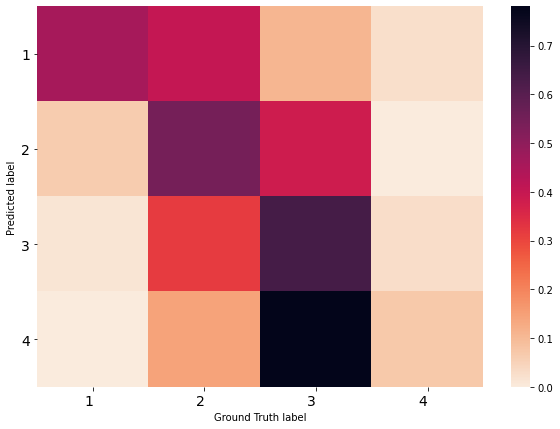

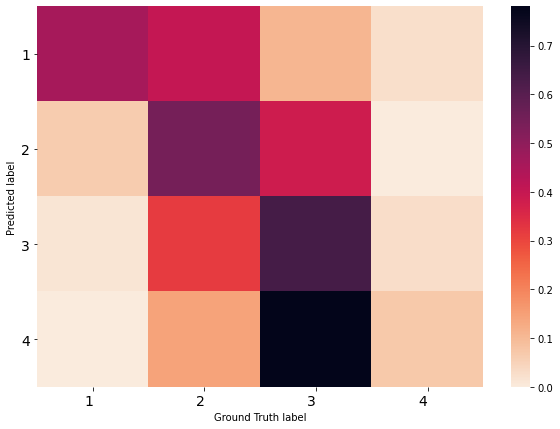

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=False, cmap=sns.cm.rocket_r)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.xlabel('Ground Truth label')
    plt.ylabel('Predicted label')
    return fig
print_confusion_matrix(matrix, alphabet)

In [ ]:
for i in range(len(show_guide)):
  print(show_guide[i],results[i],Quartile[i])

TTGGATCAGTACCTGCTTTCGCT [0.20689493] 2
TTTGGATCAGTACCTGCTTTCGC [0.40237352] 3
TTTTGGATCAGTACCTGCTTTCG [0.2751231] 2
ATTTTGGATCAGTACCTGCTTTC [0.18426487] 2
CATTTTGGATCAGTACCTGCTTT [0.19291818] 2
CCATTTTGGATCAGTACCTGCTT [0.23318473] 2
TCCATTTTGGATCAGTACCTGCT [0.22862583] 2
TTCCATTTTGGATCAGTACCTGC [0.80714804] 4
CTTCCATTTTGGATCAGTACCTG [0.3215557] 3
TCTTCCATTTTGGATCAGTACCT [0.26681194] 2
GTCTTCCATTTTGGATCAGTACC [0.18576717] 2
AGTCTTCCATTTTGGATCAGTAC [0.04324279] 2
AAGTCTTCCATTTTGGATCAGTA [0.1358863] 2
AAAGTCTTCCATTTTGGATCAGT [0.32630035] 3
CAAAGTCTTCCATTTTGGATCAG [0.66719466] 3
ACAAAGTCTTCCATTTTGGATCA [-0.02963342] 1
CACAAAGTCTTCCATTTTGGATC [0.04324699] 2
GCACAAAGTCTTCCATTTTGGAT [-0.06769282] 1
CGCACAAAGTCTTCCATTTTGGA [-0.05601101] 1
TCGCACAAAGTCTTCCATTTTGG [-0.06679591] 1
GTCGCACAAAGTCTTCCATTTTG [-0.09608593] 1
TGTCGCACAAAGTCTTCCATTTT [-0.16413966] 1
TTGTCGCACAAAGTCTTCCATTT [-0.06986933] 1
ATTGTCGCACAAAGTCTTCCATT [0.08371881] 2
CATTGTCGCACAAAGTCTTCCAT [0.08861293] 2
GCATTGTCGCACAAAGTCTTC

In [ ]:
off_target_df=pd.read_csv("Off-targets.csv")
off_target_df.head()

,gRNA,Off-target site
0,TACAATTATTGATTCACCCCGTT,ATGTTAATAACTAAGTGGAACAA
1,CTACAATTATTGATTCACCCCGT,GATGTTAACAACTAAGTGAGGCA
2,TCTACAATTATTGATTCACCCCG,AGATGTTAATAACTAGGTAGGGC
3,CAATAGAGCATTCGGGTCACCAG,ATTATCTCGTAAGCCCAGTGGCC
4,TCAATAGAGCATTCGGGTCACCA,AGTTATCTCGTAAGCCCAGTGGT


In [ ]:
gRNA = off_target_df['gRNA']
gRNA = gRNA[pd.notnull].to_numpy()
print(gRNA)

# extract target site sequences from dataframe into a numpy array
prot = off_target_df['Off-target site']
prot = prot[pd.notnull].to_numpy()
print(prot)

['TACAATTATTGATTCACCCCGTT' 'CTACAATTATTGATTCACCCCGT'
 'TCTACAATTATTGATTCACCCCG' 'CAATAGAGCATTCGGGTCACCAG'
 'TCAATAGAGCATTCGGGTCACCA' 'TTCCATTTTGGATCAGTACCTGC'
 'GGACTTCCCTCCGTGTCACCCCA' 'TGGACTTCCCTCCGTGTCACCCC'
 'CACCCCAATTTCAATGAACCGGT' 'AGGAATCCCATAGGCTCCTACTG'
 'AAAGGAATCCCATAGGCTCCTAC' 'GAAAGGAATCCCATAGGCTCCTA'
 'CGAAAGGAATCCCATAGGCTCCT' 'ACGAAAGGAATCCCATAGGCTCC']
['ATGTTAATAACTAAGTGGAACAA' 'GATGTTAACAACTAAGTGAGGCA'
 'AGATGTTAATAACTAGGTAGGGC' 'ATTATCTCGTAAGCCCAGTGGCC'
 'AGTTATCTCGTAAGCCCAGTGGT' 'AAGATAAAACCTAGTCATGGACG'
 'CCTGAAAAAAGGCATAGTGGGGT' 'ACCTGAAGGGAAACACAGTGGGG'
 'GTGGAGTTAAGGTTACTTGGCCA' 'TCCTTAGGGTATCCGAGGATGAC'
 'TTTCCTTAGGGTATCCGAGGATG' 'CTTTCCTTAGGGTATCCGAGGAT'
 'GCTTTCCTTAGGGTATCCGAGGA' 'TGCTTTCCTTAGGGTATCCGAGG']


In [ ]:
# split target into individual bases
mguide = []
mtarget = []
for i in range(len(gRNA)):
  mguide.append(split(gRNA[i]))
  mtarget.append(split(prot[i]))

print(mguide)
print(mtarget)
print(mtarget[13])

[['T', 'A', 'C', 'A', 'A', 'T', 'T', 'A', 'T', 'T', 'G', 'A', 'T', 'T', 'C', 'A', 'C', 'C', 'C', 'C', 'G', 'T', 'T'], ['C', 'T', 'A', 'C', 'A', 'A', 'T', 'T', 'A', 'T', 'T', 'G', 'A', 'T', 'T', 'C', 'A', 'C', 'C', 'C', 'C', 'G', 'T'], ['T', 'C', 'T', 'A', 'C', 'A', 'A', 'T', 'T', 'A', 'T', 'T', 'G', 'A', 'T', 'T', 'C', 'A', 'C', 'C', 'C', 'C', 'G'], ['C', 'A', 'A', 'T', 'A', 'G', 'A', 'G', 'C', 'A', 'T', 'T', 'C', 'G', 'G', 'G', 'T', 'C', 'A', 'C', 'C', 'A', 'G'], ['T', 'C', 'A', 'A', 'T', 'A', 'G', 'A', 'G', 'C', 'A', 'T', 'T', 'C', 'G', 'G', 'G', 'T', 'C', 'A', 'C', 'C', 'A'], ['T', 'T', 'C', 'C', 'A', 'T', 'T', 'T', 'T', 'G', 'G', 'A', 'T', 'C', 'A', 'G', 'T', 'A', 'C', 'C', 'T', 'G', 'C'], ['G', 'G', 'A', 'C', 'T', 'T', 'C', 'C', 'C', 'T', 'C', 'C', 'G', 'T', 'G', 'T', 'C', 'A', 'C', 'C', 'C', 'C', 'A'], ['T', 'G', 'G', 'A', 'C', 'T', 'T', 'C', 'C', 'C', 'T', 'C', 'C', 'G', 'T', 'G', 'T', 'C', 'A', 'C', 'C', 'C', 'C'], ['C', 'A', 'C', 'C', 'C', 'C', 'A', 'A', 'T', 'T', 'T', 'C', 'A

In [ ]:
test = transform(mtarget[14])
test2 = transform (mguide[0])
print(test)
print(test2)


IndexError: ignored

In [ ]:
# concatenate the mguide and mtarget arrays into the final encoded format
x_encoded=[]
for i in range(len(gRNA)):
  print(i)
  fguide=[]
  fguide = transform(mguide[i])
  ftarget=[]
  ftarget = transform(mtarget[i])
  fguide = np.array(np.expand_dims(fguide, axis = 1))
  ftarget = np.array(np.expand_dims(ftarget, axis = 1))
  #final_match = ftarget+fguide
  final_match = np.concatenate((fguide, ftarget), axis=1)
  final_match = final_match.reshape(46, 4)
  x_encoded.append(final_match)
# test with one encoded format
print(x_encoded[0])
print(guide[0])
# x_final=np.array(x_encoded)
# print(x_final[0]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
[[0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]]
TTAAAATCACATGGGGATAGCAC


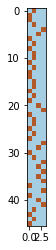

In [ ]:
# graph of the encoded format
plt.imshow(x_encoded[0], cmap = 'Paired', interpolation = 'nearest')

In [ ]:
x_encoded = np.expand_dims(x_encoded, axis=3)
x_encoded.shape

(14, 46, 4, 1)

In [ ]:
model.predict(x_encoded)

array([[0.26265657],
       [1.098981  ],
       [0.6586005 ],
       [0.6208705 ],
       [0.95298433],
       [0.6925808 ],
       [0.6826663 ],
       [0.6924941 ],
       [0.6247252 ],
       [0.9459576 ],
       [1.3378752 ],
       [1.0262278 ],
       [1.0224402 ],
       [0.8441989 ]], dtype=float32)

In [ ]:
transform(spl("TCCAG"))

In [ ]:
  def transforms(basepairs):
    for i in range(0,5):
  
      if basepairs[i] == "A":
        basepairs.remove(basepairs[i])
        basepairs.insert(i,[1,0,0,0])
      if basepairs[i] == "T":
        basepairs.remove(basepairs[i])
        basepairs.insert(i,[0,1,0,0])
      if basepairs[i] == "G":
        basepairs.remove(basepairs[i])
        basepairs.insert(i,[0,0,1,0])
      if basepairs[i] == "C":
        basepairs.remove(basepairs[i])
        basepairs.insert(i,[0,0,0,1])
    return basepairs
  sample=transforms(spl("AGGTC"))
  plt.imshow(sample, interpolation='nearest')


NameError: ignored

In [ ]:
def plot_filters (layer, x,y):
  filters = model.layers[layer].get_weights()[0][:,:,0,:]
  fig=plt.figure()
  for i in range(len(filters)):
    ax=fig.add_subplot(y,x,i+1)
    ax.matshow(filter[j][0], cmap= matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
  plt.tight_layout
  return plt

plot_filters(model.layers[0],2,1)

TypeError: ignored

In [ ]:
filters, biases = model.layers[2].get_weights()
filters[0][0][0]

In [ ]:
model.layers[0]

In [ ]:

for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)


In [ ]:
pred1=model.predict(x_test)
pred1.shape

In [ ]:
print(type(y_test))


In [ ]:
plt.figure(figsize=(100,30))
plt.scatter(range(0,217),pred1, color="red")
plt.plot(range(0,217),y_test, color="blue")



In [ ]:
d=0
sum_mean_sq=0
for i in range(0,len(pred1)):
  dif=pred1[i]-y_test[i]
  d=d+dif**2
  

mse_pred1=d/len(pred1)
print("mse of pred1: {}".format(mse_pred1))

for i in range (0,len(y_test)):
  mean=y_test[i]/len(y_test)
  sum_mean_sq=sum_mean_sq+(y_test[i]-mean)**2
  r_squared=1-(d/sum_mean_sq)
print("R squared of pred1: {}".format(r_squared))
